<a href="https://colab.research.google.com/github/joaomarciel2/reconhecimento_facial/blob/main/face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Reconhecimento Facial - Desafio DIO

**Visão geral do que vamos construir**

1.   Detectar rostos com MTCNN;
2.   Alinhar e recortar cada rosto e padronizar tamanho;
3.   Extrair embeddings (vetores de 512 dim) com FaceNet, do Keras;
4.   Treinar um classificador (Regressão Logística) com esses vetores;
5.   Inferência: detectar -> embed -> classificar -> desenhar labels.



### Preparar o ambiente do Colab

Será necessário mudar o tipo de Ambiente de Execução para **"GPU"**.


*   No Colab, vá em **Ambiente de execução** -->   **Alterar o tipo de ambiente de execução** --> **Acelerador de hardware: GPU**.


### Importação e checagens

In [2]:
!nvidia-smi -L || true

# Bibliotecas
!pip -q install mtcnn keras-facenet scikit-learn imutils

import os, glob, math, pickle, cv2, numpy as np
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN
from keras_facenet import FaceNet
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

GPU 0: Tesla T4 (UUID: GPU-f64aca41-857e-6fd0-aeab-93522ca9516d)


### Estrutura do Dataset

No meu caso, o dataset está em um arquivo .ZIP.
Para isso, é necessário subir o arquivo .ZIP na aba **Arquivos** do Colab e, depois, extrair ela com o seguinte comando:

In [9]:
!unzip -q /content/dataset.zip -d /content/data

### Utilitários: mostrar imagem e desenhar caixas

In [10]:
def show_bgr(img_bgr, title=None):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,6))
    if title: plt.title(title)
    plt.axis('off')
    plt.imshow(img_rgb)
    plt.show()

def draw_box_and_label(img, box, label, conf=None):
    x, y, w, h = box
    cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 2)
    text = label if conf is None else f"{label} ({conf:.2f})"
    cv2.putText(img, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX,
                0.6, (0,255,0), 2, cv2.LINE_AA)

### Detecção de Rostos (MTCNN) + alinhamento

In [11]:
detector = MTCNN()

def detect_faces_bgr(img_bgr, min_conf=0.90):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    dets = detector.detect_faces(img_rgb)
    out = []
    for d in dets:
        if d.get('confidence', 0) >= min_conf:
            x, y, w, h = d['box']
            # Corrige boxes negativos (MTCNN às vezes retorna)
            x, y = max(x, 0), max(y, 0)
            out.append({
                "box": (x, y, w, h),
                "keypoints": d.get('keypoints', {}),
                "confidence": d['confidence']
            })
    return out

def align_and_crop_face(img_bgr, box, keypoints, image_size=160, margin=0.2):
    x, y, w, h = box
    # calcula ângulo dos olhos
    le = keypoints.get('left_eye', None)
    re = keypoints.get('right_eye', None)

    # região com margem
    cx, cy = x + w/2, y + h/2
    m = margin
    size = int(max(w, h) * (1 + m))
    x1 = int(max(cx - size/2, 0))
    y1 = int(max(cy - size/2, 0))
    x2 = int(min(cx + size/2, img_bgr.shape[1]-1))
    y2 = int(min(cy + size/2, img_bgr.shape[0]-1))
    crop = img_bgr[y1:y2, x1:x2].copy()

    # se tivermos olhos, alinhe por rotação
    if le is not None and re is not None:
        # ajusta coords para o crop
        le_ = (le[0]-x1, le[1]-y1)
        re_ = (re[0]-x1, re[1]-y1)
        dy = re_[1] - le_[1]
        dx = re_[0] - le_[0]
        angle = math.degrees(math.atan2(dy, dx))
        M = cv2.getRotationMatrix2D((crop.shape[1]/2, crop.shape[0]/2), angle, 1.0)
        crop = cv2.warpAffine(crop, M, (crop.shape[1], crop.shape[0]), borderMode=cv2.BORDER_REPLICATE)

    face = cv2.resize(crop, (image_size, image_size), interpolation=cv2.INTER_AREA)
    return face

### Teste rápido com qualquer imagem da base

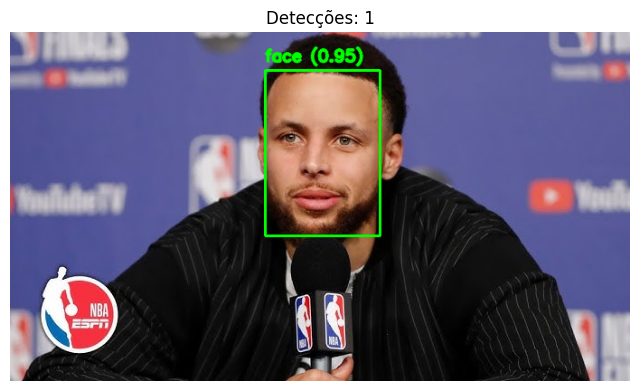

In [13]:
test_path = "/content/data/curry/curry 105.jpg"  #coloque o caminho de uma imagem para testar
if test_path:
    img = cv2.imread(test_path)
    dets = detect_faces_bgr(img, min_conf=0.9)
    img_dbg = img.copy()
    for d in dets:
        draw_box_and_label(img_dbg, d["box"], "face", d["confidence"])
    show_bgr(img_dbg, f"Detecções: {len(dets)}")

### Embeddings (vetores) com FaceNet

In [14]:
embedder = FaceNet()

def embed_face_bgr(face_bgr):
    # FaceNet espera RGB e float32 normalizado
    face_rgb = cv2.cvtColor(face_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)
    # A classe FaceNet do keras-facenet já faz o pré-processamento
    embs = embedder.embeddings([face_rgb])  # lista de 1
    return embs[0]  # (512,)

### Preparar dados: Detectar -> Alinhar -> Embutir (Train/Val)

In [18]:
from sklearn.model_selection import train_test_split

def list_images_split(base_dir, train_size=0.3, random_state=42):
    train_paths, val_paths = [], []
    classes = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])
    for c in classes:
        all_imgs = [ (p, c) for p in glob.glob(os.path.join(base_dir, c, "*"))
                     if p.lower().endswith((".jpg",".jpeg",".png",".bmp",".webp")) ]
        tr, va = train_test_split(all_imgs, train_size=train_size, random_state=random_state)
        train_paths.extend(tr)
        val_paths.extend(va)
    return train_paths, val_paths, classes

def build_Xy_from_list(paths, min_conf_det=0.90, image_size=160):
    X, y = [], []
    skipped = 0
    for p, c in paths:
        img = cv2.imread(p)
        if img is None:
            skipped += 1
            continue
        dets = detect_faces_bgr(img, min_conf=min_conf_det)
        if not dets:
            skipped += 1
            continue
        d = sorted(dets, key=lambda z: z["confidence"], reverse=True)[0]
        face = align_and_crop_face(img, d["box"], d["keypoints"], image_size=image_size)
        emb = embed_face_bgr(face)
        X.append(emb)
        y.append(c)
    X = np.vstack(X).astype("float32")
    y = np.array(y)
    return X, y, skipped

# agora usa
train_paths, val_paths, classes = list_images_split("data", train_size=0.3)

X_train, y_train, skipped_tr = build_Xy_from_list(train_paths)
X_val,   y_val,   skipped_va = build_Xy_from_list(val_paths)

print("Train:", X_train.shape, "Val:", X_val.shape)
print("Puladas (sem detecção/erro):", skipped_tr, skipped_va)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

### Treinar o classificador
Nesse caso, foi utilizado a Regressão Logística (Logistic Regression), mas pode ser testado também em SVM.

Para isso, somente trocar o clf para image.png

In [19]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)

clf = LogisticRegression(max_iter=2000, n_jobs=None)  # n_jobs para versões recentes do sklearn
clf.fit(X_train, y_train_enc)

pred_val = clf.predict(X_val)
proba_val = clf.predict_proba(X_val)
acc = accuracy_score(y_val_enc, pred_val)
print("Val ACC:", acc)
print(classification_report(y_val_enc, pred_val, target_names=le.classes_))

Val ACC: 0.966824644549763
              precision    recall  f1-score   support

       curry       0.96      0.97      0.97       107
      lebron       0.97      0.96      0.97       104

    accuracy                           0.97       211
   macro avg       0.97      0.97      0.97       211
weighted avg       0.97      0.97      0.97       211



### Salvar e carregar o pipeline

In [21]:
os.makedirs("artifacts", exist_ok=True)
with open("artifacts/label_encoder.pkl","wb") as f: pickle.dump(le, f)
with open("artifacts/classifier.pkl","wb") as f: pickle.dump(clf, f)

with open("artifacts/label_encoder.pkl","rb") as f: le = pickle.load(f)
with open("artifacts/classifier.pkl","rb") as f: clf = pickle.load(f)

### Inferência em imagens novas

Nesse caso, peguei uma imagem que não estava nem na base de treino ou de teste, e subi ela no Colab, para conferir se o algoritmo está detectando de forma correta.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[{'box': (260, 149, 102, 144), 'confidence_det': np.float64(0.9999991059303284), 'label': np.str_('curry'), 'confidence_cls': 0.9160872013946735}, {'box': (720, 79, 105, 137), 'confidence_det': np.float64(0.9999787211418152), 'label': np.str_('lebron'), 'confidence_cls': 0.898578566763051}]


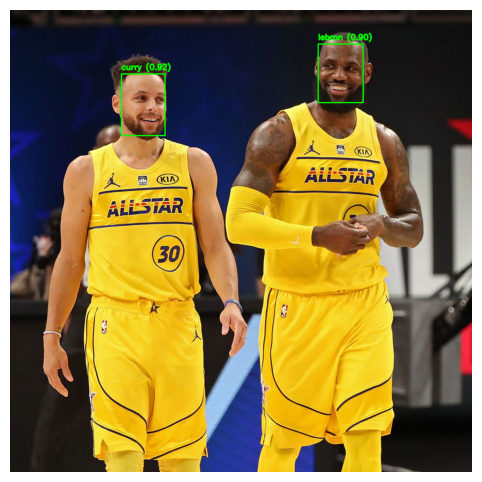

In [32]:
def predict_faces_on_image(img_bgr, clf, le, min_conf_det=0.90, min_conf_cls=0.50):
    dets = detect_faces_bgr(img_bgr, min_conf=min_conf_det)
    out = img_bgr.copy()
    results = []
    for d in dets:
        face = align_and_crop_face(out, d["box"], d["keypoints"], image_size=160)
        emb  = embed_face_bgr(face).reshape(1,-1)
        proba = clf.predict_proba(emb)[0]           # vetor por classe
        idx   = int(np.argmax(proba))
        conf  = float(proba[idx])
        label = le.classes_[idx] if conf >= min_conf_cls else "desconhecido"
        draw_box_and_label(out, d["box"], label, conf)
        results.append({
            "box": d["box"],
            "confidence_det": d["confidence"],
            "label": label,
            "confidence_cls": conf
        })
    return out, results

# Exemplo:
test_path = "curry_and_lebron.jpg"  # coloque o caminho de uma foto
if test_path:
    img = cv2.imread(test_path)
    vis, res = predict_faces_on_image(img, clf, le, min_conf_det=0.90, min_conf_cls=0.75)
    print(res)  # lista com caixas + rótulos + confianças
    show_bgr(vis)